In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from astroNN.nn.layers import MCDropout
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
import math


In [31]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA2.h5') 
autoencoder = tf.keras.models.load_model('../models/autoencoderCONV_JLA.h5')
# ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5') 
ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})
# autoencoderCONV_JLA.h5

In [32]:
ffnn_do.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 200)               400       
_________________________________________________________________
MCDropout_1 (MCDropout)      (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               10200     
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 200)               0     

In [3]:

def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix          



In [4]:
file = '../data/jla_binned_distances_31nodes_v1.txt'
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))


data = pd.read_csv(file, names=['z', '$D_L$'], sep = " ", skiprows=3)

z = data.values[:,0]
dl = data.values[:,1]


scalerdl = StandardScaler()
scalerdl.fit(dl.reshape(-1, 1))


nsize = len(syscov)
scaler_sys = StandardScaler()
scaler_sys.fit(syscov)
syscov = scaler_sys.transform(syscov)

magnitudes = matrixMag(syscov)

In [5]:
# using original values
ranz = z
# 
# ranz = np.linspace(0.1, 1.3, 31)
index = np.argsort(ranz)

pred_random = ffnn.predict(np.log(ranz))
# pred_dl = scalerdl.inverse_transform(pred_random[:,0].reshape(-1,1))
pred_dl = pred_random[:,0]
pred_err = np.exp(pred_random[:,1][index].reshape(-1,1))
# dlfake = scalerdl.inverse_transform(pred_random.reshape(-1,1))

In [6]:
np.shape(pred_random), np.shape(pred_dl), np.shape(pred_err)

((31, 2), (31,), (31, 1))

In [7]:
fake_data = np.stack((ranz[index], pred_dl.reshape(31,)[index]), axis=1)

np.savetxt("fake_binned_JLA2TEST1.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')



In [8]:
Om = 0.27
# variance network
w0 = -1

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa):
#         if model == 'lcdm':
#             return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
#         elif model == 'owacdm':
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, w0=-1, wa=0.0):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, w0, wa)*(1+z))+43

In [9]:
zmodel = np.linspace(0.005, 1.4, 100)
flcdm = []
fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
    fowacdm1.append(distance_modulus(zzz, w0=-10, wa=-100))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

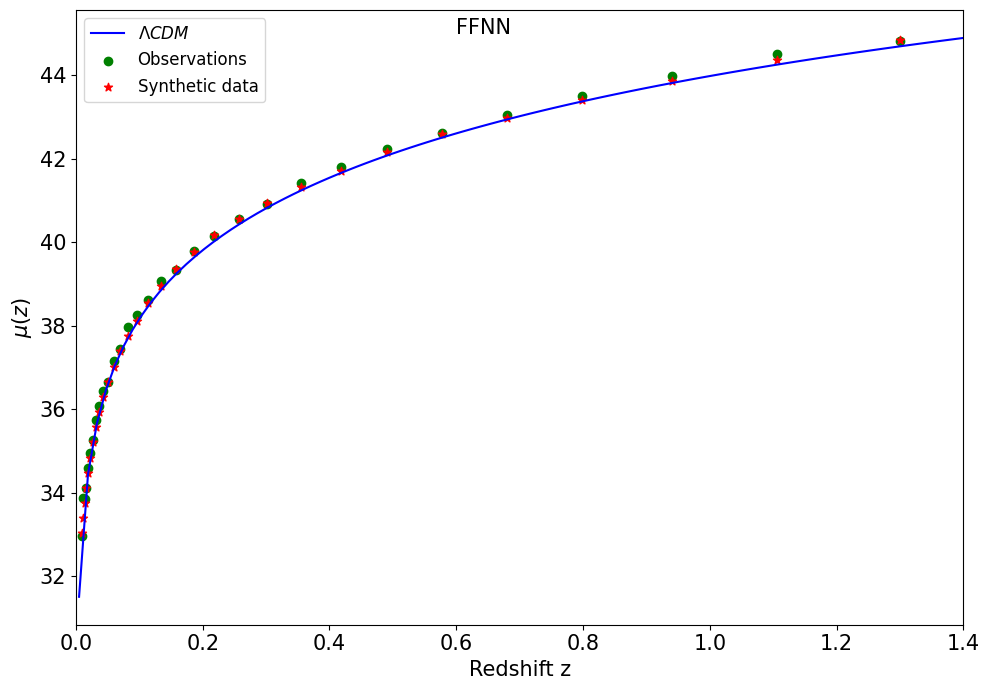

In [34]:
plt.figure(figsize=(10, 7), dpi=100)
# plt.errorbar(ranz, pred_random, yerr=0, fmt='r.', markersize=10.)
# plt.scatter(z, dl)
plt.scatter(z, dl,c='g', label='Observations')
plt.scatter(ranz, pred_dl, c='r', label='Synthetic data', marker='*')
# plt.errorbar(z, dl, yerr=0, fmt='g.', markersize=10, label='Observations')
# plt.errorbar(ranz, pred_random, 
#              yerr=0, fmt='r.', markersize=10., label='Synthetic data')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(zmodel, fowacdm1, label='CPL $w_0 = -1.3, w_a=1.2$', c='m')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xlim(-0.0, np.max(z)+0.1)
plt.xticks(fontsize=15)
plt.text(0.6, 45, 'FFNN', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=12)
plt.savefig('jla3.png')

In [11]:
pred_err = np.diag(pred_err.reshape(31,))
np.shape(pred_err)

(31, 31)

<AxesSubplot:>

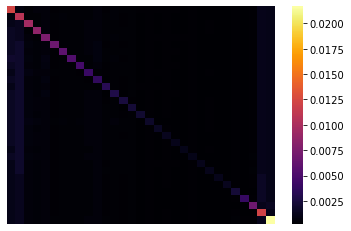

In [12]:
nsize = len(pred_err)
filled_matrix = np.zeros((nsize, nsize))
pred_err_sc = scaler_sys.transform(pred_err)

# err = np.random.randn()
for row in range(nsize):
    for col in range(nsize):
        if row == col:
#             err = np.random.randn()
#             filled_matrix[row, col] = syscov[row, col] 
            filled_matrix[row, col] = pred_err_sc[row, col] 
#             filled_matrix[row, col] = 10
#     + 0.1*err*magnitudes[row, col]
        else:
            filled_matrix[row, col] = 0.1*np.abs(magnitudes[row, col]) # this work with original syscov
#             filled_matrix[row, col] = 0.1*np.random.rand()

sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(filled_matrix)),  
            xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)



Text(0.5, 1.0, 'Reconstructed matrix with conv-AE')

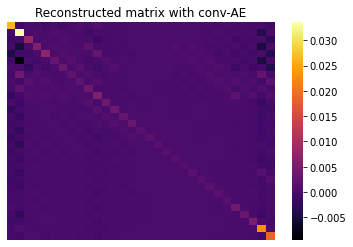

In [13]:
clean_img = autoencoder.predict(filled_matrix.reshape(1,31,31,1))

clean_imgr = scaler_sys.inverse_transform(clean_img[0,:,:,0])

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)




plt.title('Reconstructed matrix with conv-AE')

In [14]:
np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_imgr.reshape(31,31), delimiter= " ", header="#fake COV")

In [15]:
# count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
#         if np.iscomplex(syscov[i,j]):
#             print("COMPLEX")
        if clean_imgr[i,j] < clean_imgr[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
#             count+=1
            clean_imgr[j,i] = clean_imgr[i, j]
        else:
            clean_imgr[i, j] = clean_imgr[j, i]

In [16]:
np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_imgr.reshape(31,31), delimiter= " ", header="#fake COV")

In [27]:
magnitudes

array([[ 0.,  0.,  0., -2., -1., -1., -1., -1., -1., -1., -1., -1., -2.,
        -2., -1., -3., -1., -2., -2., -2., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0., -1., -2., -2., -1., -2., -1., -1., -2., -2.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1.],
       [-1., -1.,  0.,  0., -1., -1., -1., -1., -1., -2., -1., -3., -1.,
        -1., -2., -1., -1., -1., -1., -1., -1., -2., -2., -2., -1., -1.,
        -1., -1., -1., -1., -1.],
       [-2., -1.,  0.,  0., -1., -1., -1., -1., -1., -2., -1., -2., -1.,
        -2., -2., -1., -1., -1., -1., -1., -1., -2., -1., -2., -1., -1.,
        -1., -1., -1., -1., -1.],
       [-2., -1., -1.,  0.,  0.,  0., -1., -1., -1., -2., -1., -2., -2.,
        -3., -2., -2., -1., -2., -1., -2., -4., -2., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1.],
       [-2., -2., -2., -1., -1.,  0.,  0., -1., -1., -2., -2., -1., -1.,
        -1., -1., -1., -1.,

<AxesSubplot:>

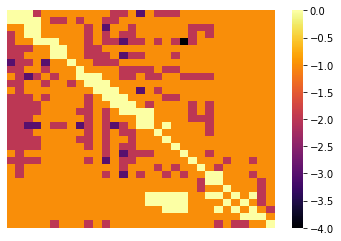

In [21]:
sns.heatmap(pd.DataFrame(magnitudes), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

0.5395778306689847


(None, 0.01831563888873418, 6.14421235332821e-06)

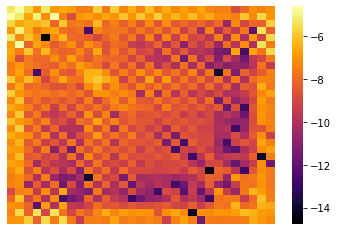

In [18]:
# nsize = len(pred_err)
suma = 0
percentage_matrix = np.zeros((nsize, nsize))
syscov = scaler_sys.inverse_transform(syscov.reshape(31,31))
# pred_err_sc = scaler_sys.transform(pred_err)

# err = np.random.randn()
for row in range(nsize):
    for col in range(nsize):
        percentage_matrix[row, col] = np.abs(clean_imgr[row, col]-syscov[row, col])
        suma += percentage_matrix[row, col]
        
sns.heatmap(pd.DataFrame(np.log(percentage_matrix)),  
            xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

print(suma), np.exp(-4), np.exp(-12)

In [19]:
np.min(percentage_matrix), np.max(percentage_matrix)

(3.907710570179995e-07, 0.009995552197368779)

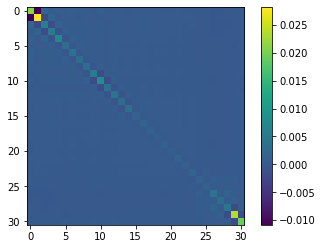

In [26]:
plt.imshow(syscov)
plt.colorbar()